<a href="https://colab.research.google.com/github/nmarkin/DL_corse/blob/main/Lesson_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning
# Урок 2

## Часть 1

На прошлом уроке мы подробно рассмотрели модель логистической регрессии, которая является по сути моделью одного-единственного нейрона. Вспомним формулы, которые мы получили на прошлом уроке.

### Формулы, описывающие forward_propagation:

$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$

$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)}).\tag{2}$$ 


### Формулы, описывающие текущую ошибку на i-ом тренировочном образце и усредненную ошибку по всему тренировочному сету:

$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)}).\tag{4}$$
<br>
### Формулы, описывающие back_propagation:

$$ \frac{\partial J}{\partial w}=\nabla J_w = \frac{1}{m}X(A-Y)^T\tag{5}$$

$$ \frac{\partial J}{\partial b} =\frac{dJ}{db}= \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)}).\tag{6}$$

## Часть 2

На уроке этой недели мы построим простую двуслойную нейронную сеть и сравним качество ее работы с качеством логистической регрессии. Для этого будем использовать датасет, в котором объекты не являются линейно разделимыми. Объявим несколько служебных функций для генерации такого датасета и отрисуем его с помощью библиотеки matplotlib.pyplot:

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

In [12]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.figure(figsize=(14,8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    
    #plt.figure(figsize=(14,8))
    plt.scatter(X[0, :], X[1, :], c=y[0], cmap=plt.cm.Spectral)
    #plt.show()

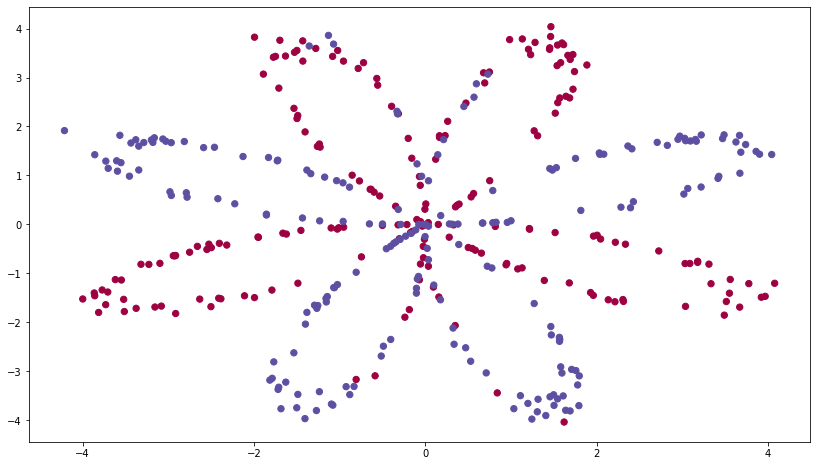

In [13]:
X, Y = load_planar_dataset() #загружаем датасет
plt.figure(figsize=(14,8))
plt.scatter(X[0, :], X[1, :], c=Y[0], s=40, cmap=plt.cm.Spectral);

Итак, мы убедились, что объекты датасета не являются линейно разделимыми. Посмотрим, какой ответ выдаст логистическая регрессия на таком наборе данных:

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


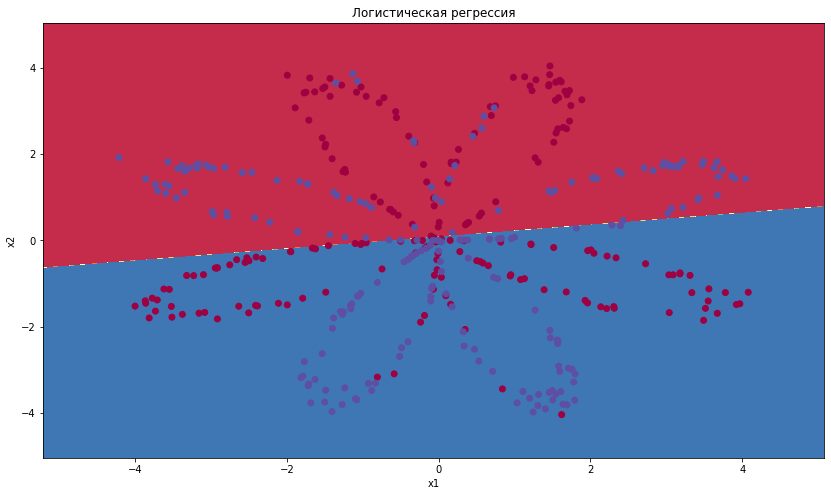

Качество модели (согласно метрике accuracy): 47 % 


In [14]:
from sklearn.linear_model import LogisticRegression     # IMPORT MODEL FROM SKLEARN

clf = LogisticRegression()                              # INITIALIZE MODEL
clf.fit(X.T, Y.T)                                       # FIT THE MODEL

plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title(u"Логистическая регрессия")
plt.show()
# Print accuracy
LR_predictions = clf.predict(X.T)
print (u'Качество модели (согласно метрике accuracy): %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ')

Как видно по рисунку и по метрике качества, логистическая регрессия оказалась неспособной к аппроксимации такого датасета. Теперь мы соберём простую нейронную сеть и посмотрим, сумеем ли мы улучшить качество предсказаний. Для нашей задачи будем использовать архитектуру, изображенную на рисунке ниже:

<img src="https://drive.google.com/uc?export=view&id=1P-2gbftz64eO0R60JvCvP6clxUs4REU1" style="width:665px;height:320px;">

Такая нейросеть называется двуслойной полносвязной нейросетью ($\textit{2-layer fully connected neural network})$ или нейросетью с одним скрытым слоем ($\textit{1-hidden layer neural network}$). 

Слоем нейросети называется совокупность нейронов, на вход которых поступают одни и те же данные. А отличаются нейроны в одном слое значением вектора весов (он же вектор параметров). Пример с картинки: в нейрон $a_1^{[1]}$ и в $a_2^{1}$ поступают одни и те же данные $x_1$ и $x_2$  соответственно. Но на выход из первого нейрона мы получаем: 

$$\sigma(w_1^{[1][1]} \cdot x_1+w_1^{[1][2]} \cdot x_2),$$

а на выход из второго нейрона имеем:

$$\sigma(w_2^{[1][1]} \cdot x_1+w_2^{[1][2]} \cdot x_2).$$

Также существенно, что у нейронов одного слоя $\textbf{должны совпадать функции активации}$!

Поясним, что описывает каждый индекс при весе $w:$ первый верхний индекс - это номер слоя, нижний индекс - это номер нейрона в слое, второй верхний индекс - это номер веса. Верхний индекс i в круглых скобочках применяется для вывода данного нейрона на i-ом образце датасета.



In [15]:
### В этой функции необходимо описать архитектуру сети, то есть размерность каждого слоя

def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    ### START CODE HERE ###
    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]
    ### END CODE HERE ###
    return (n_x, n_h, n_y)

In [16]:
#Проинициализируйте веса w модели случайными числами из нормального распределения, а смещения b нулями
def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2) # ЭТУ_СТРОКУ_НЕ_РЕДАКТИРОВАТЬ
    
    ### START CODE HERE ###
    W1 = np.random.standard_normal(size=(n_h, n_x))
    b1 = 0
    W2 = np.random.standard_normal(size=(n_y, n_h))
    b2 = 0
    ### END CODE HERE ###
        
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

Итак, мы задали модель. Осталось добавить шаги обучения и предсказания и все это скомпоновать.

### Forward_prop

Теперь опишем всю цепочку вычислений, происходящую с данными, необходимую для получения вывода $\hat{y}$ для  $x$:

$$ z^{[1]} = W^{[1]}\cdot x + b^{[1]} \tag{1.1}$$

$$ a^{[1]} = \sigma^{[1]} (z^{[1]}) \tag{1.2}$$


$$ z^{[2]} = W^{[2]} \cdot a^{[1]} + b^{[2]} \tag{2.1} $$

$$ a^{[2]} = \sigma^{[2]} (z^{[2]}) \tag{2.2} $$

$$ J(a^{[2]}, y) = ... \tag{3.1}$$

$$ y = threshold(a^{[2]}). \tag{3.2}$$

Полученное $\textbf{число}$ $y^{(i)}$ - это окончательный вывод (ответ) нейронной сети: в данном случае 0 или 1. 

Множество значений, которое принимает число $a^{[2]}$, зависит от выбора функции активации последнего слоя (в данной нейросети два слоя - следовательно, оно определяется выбором функции $\sigma^{[2]}$). 

В качестве функции $\sigma^{[1]}$ выберем гиперболический тангенс, в качестве $\sigma^{[2]}$ - сигмоиду.

In [17]:
# Опишите в данной функции forward_propagation согласно формулам выше

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    ### START CODE HERE ###
    Z1 = W1 @ X + b1
    A1 = np.tanh(Z1)
    Z2 = W2 @ A1 + b2
    A2 = 1 / (1 + np.exp(-Z2))
    ### END CODE HERE ###
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

### Back_prop

**OFFTOP**  Мы видим, что подсчет вывода каждого слоя подразумевает матричные вычисления. Именно этот шаг позволяет добиться существенного ускорения, если разворачивать нейросеть на GPU, ядра которого специально рассчитаны для подобных вычислений.

Вернёмся к математике... Сверху мы описали шаг forward propagation (т.е. подсчет вывода и функции ошибки на нём). Зададим ту же функцию ошибки, что и в задаче логистической регрессии (binary cross entropy)

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{4}$$


**REMINDER:** Под записью $dw$ мы подразумеваем запись вектора  $\nabla_w J$, где $J$ - скалярная функция, заданная в выражении $1$.

$$dz^{[2]} = a^{[2]}-y \tag{5.1}$$

$$dw^{[2]} = \frac{\partial J}{\partial z^{[2]}} \cdot \frac{\partial z^{[2]}}{\partial w^{[2]}}  = \frac{1}{m}\cdot dz^{[2]} \cdot a^{[1]T} \tag{5.2}$$

$$db_j^{[2]} = \frac{1}{m} \sum_{i=1}^{m} {dz_{j}^{[2](i)}} ,  j = \{1\} \tag{5.3}$$

$$dz^{[1]} =  \frac{\partial J}{\partial a^{[1]}} * \frac{\partial a^{[1]}}{\partial z^{[1]}} = w^{[2]T} \cdot dz^{[2]}* \frac{\partial a^{[1]}}{\partial z^{[1]}} \tag{6.1}$$

$$dw^{[1]} = \frac{\partial J}{\partial a^{[1]}} \cdot \frac{\partial a^{[1]}}{\partial w^{[1]}} =  \frac{1}{m} \cdot dz^{[1]} \cdot x^{T}\tag{6.2}$$

$$db_{j}^{[1]} =\frac{1}{m}\sum_{i=1}^m {dz_j^{[1](i)}} , j =\{1,2,3,4\} \tag{6.3} $$

**ВАЖНО!!!** 
Необходимо отметить, что знак $\cdot$ мы используем для скалярного произведения (numpy.dot()), в то время как знак $*$ используется для поэлементного перемножения двух векторов (numpy.multiply()). 

Подсказка: чтобы упростить вычисление производной гиперболического тангенса $\frac{\partial a^{[1]}}{\partial z^{[1]}}$, можно воспользоваться данным равенстовом: $$\frac{d \tanh(x)}{dx}= 1 - \tanh(x)^2, \tag{7.1}$$

используйте NumPy: 1 - np.power(A1, 2).

Равенство можно доказать простым дифференцированием.

In [18]:
# Подсчитайте функцию потерь
def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (formula 4)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    
    m = Y.shape[1] # number of example

    
    ### START CODE HERE ###
    
    logprobs = Y * np.log(A2) + (1-Y) * np.log(1-A2)
    cost = - logprobs.sum() / m
    
    ### END CODE HERE ###
    
    return cost

In [19]:
#Реализуйте шаг backprop

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    ### START CODE HERE ###
    dZ2 = A2 - Y
    dW2 = 1/m * dZ2 @ A1.T
    db2 = 1/m * dZ2.sum()
    dZ1 = W2.T @ dZ2 * (1 - np.power(A1, 2))
    dW1 = 1/m * dZ1 @ X.T
    db1 = 1/m * dZ1.sum()
    ### END CODE HERE ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [20]:
#Шаг обновления параметров

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
   
    ### START CODE HERE ###
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

Теперь соберем все функции в одну модель...

In [21]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Инициализируйте параметры. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    
    ### START CODE HERE ###
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    
    # Loop (градиентный спуск)

    for i in range(0, num_iterations):
         
        ### START CODE HERE ###
       # Шаг forward propagation
        A2, cache = forward_propagation(X, parameters)
        
        # Подсчет функции потерь
        cost = compute_cost(A2, Y, parameters)
 
        # Шаг backpropagation
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Обновление весов
        parameters = update_parameters(parameters, grads)
        
        ### END CODE HERE ###
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [22]:
# Реализуйте функции для вывода предсказания
def predict(parameters, X, threshold = 0.5):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    threshold -- used for defining prediction
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    A2, cache = forward_propagation(X, parameters)
    predictions = (A2>threshold).astype(int)
    ### END CODE HERE ###
    
    return predictions

Cost after iteration 0: 1.127380
Cost after iteration 1000: 0.289172
Cost after iteration 2000: 0.277022
Cost after iteration 3000: 0.268653
Cost after iteration 4000: 0.263671
Cost after iteration 5000: 0.260331
Cost after iteration 6000: 0.257915
Cost after iteration 7000: 0.256075
Cost after iteration 8000: 0.254613
Cost after iteration 9000: 0.253411
Качество модели (согласно метрике accuracy): 0.915000 


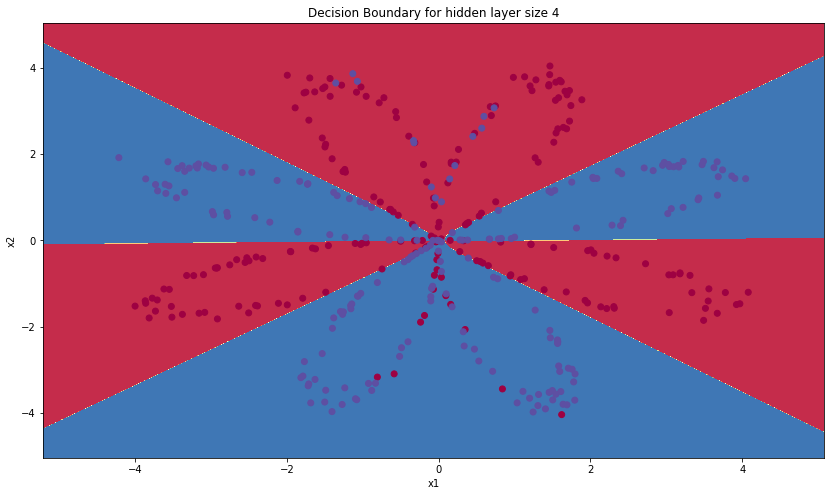

In [56]:
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Отрисуем вывод нейросети на плоскости
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

predictions = predict(parameters, X)
acc = 1 - (np.abs(Y-predictions).sum()/Y.size)
print(u'Качество модели (согласно метрике accuracy): %f ' %(acc))

##Эксперименты

Cost after iteration 0: 0.873833
Cost after iteration 1000: 0.602470
Cost after iteration 2000: 0.600701
Cost after iteration 3000: 0.599708
Cost after iteration 4000: 0.599032
Cost after iteration 5000: 0.598528
Cost after iteration 6000: 0.598129
Cost after iteration 7000: 0.597800
Cost after iteration 8000: 0.597522
Cost after iteration 9000: 0.597281
Качество модели (согласно метрике accuracy): 0.730000 


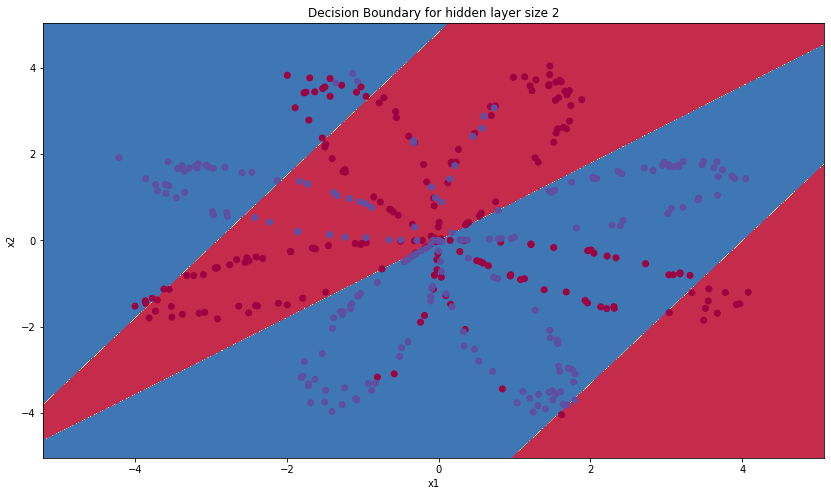

In [62]:
parameters = nn_model(X, Y, n_h = 2, num_iterations = 10000, print_cost=True)

# Отрисуем вывод нейросети на плоскости
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(2))

predictions = predict(parameters, X)
acc = 1 - (np.abs(Y-predictions).sum()/Y.size)
print(u'Качество модели (согласно метрике accuracy): %f ' %(acc))

Cost after iteration 0: 0.817689
Cost after iteration 1000: 0.570140
Cost after iteration 2000: 0.564972
Cost after iteration 3000: 0.562320
Cost after iteration 4000: 0.560369
Cost after iteration 5000: 0.558781
Cost after iteration 6000: 0.557454
Cost after iteration 7000: 0.556328
Cost after iteration 8000: 0.555361
Cost after iteration 9000: 0.554523
Качество модели (согласно метрике accuracy): 0.672500 


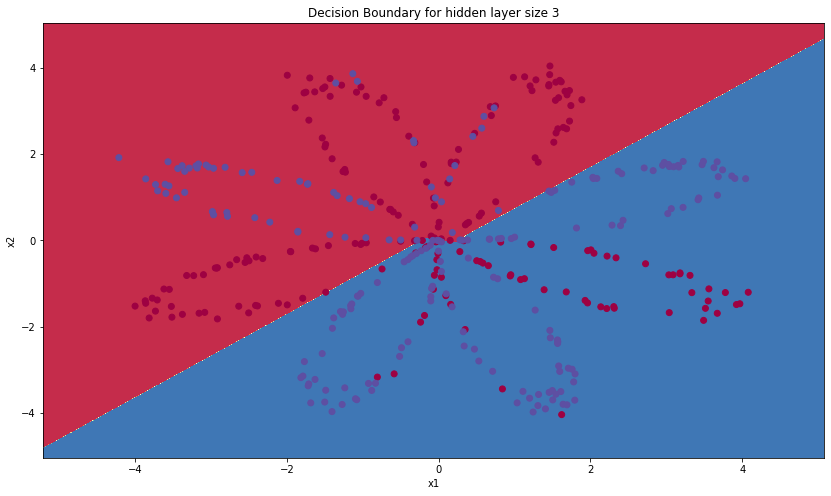

In [65]:
parameters = nn_model(X, Y, n_h = 3, num_iterations = 10000, print_cost=True)

# Отрисуем вывод нейросети на плоскости
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(3))

predictions = predict(parameters, X)
acc = 1 - (np.abs(Y-predictions).sum()/Y.size)
print(u'Качество модели (согласно метрике accuracy): %f ' %(acc))

Cost after iteration 0: 1.848618
Cost after iteration 1000: 0.212276
Cost after iteration 2000: 0.196477
Cost after iteration 3000: 0.189145
Cost after iteration 4000: 0.184205
Cost after iteration 5000: 0.180482
Cost after iteration 6000: 0.177624
Cost after iteration 7000: 0.175413
Cost after iteration 8000: 0.173674
Cost after iteration 9000: 0.172275
Качество модели (согласно метрике accuracy): 0.917500 


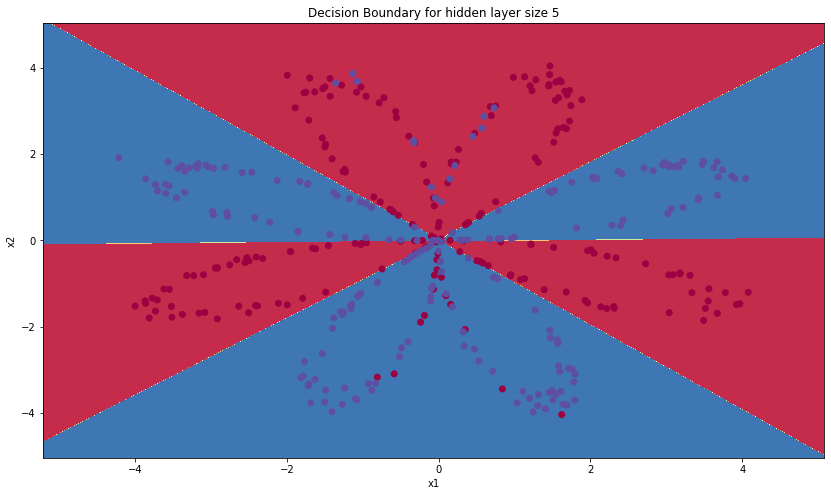

In [66]:
parameters = nn_model(X, Y, n_h = 5, num_iterations = 10000, print_cost=True)

# Отрисуем вывод нейросети на плоскости
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(5))

predictions = predict(parameters, X)
acc = 1 - (np.abs(Y-predictions).sum()/Y.size)
print(u'Качество модели (согласно метрике accuracy): %f ' %(acc))

Cost after iteration 0: 0.653166
Cost after iteration 1000: 0.284519
Cost after iteration 2000: 0.267923
Cost after iteration 3000: 0.258813
Cost after iteration 4000: 0.253337
Cost after iteration 5000: 0.249227
Cost after iteration 6000: 0.203859
Cost after iteration 7000: 0.176969
Cost after iteration 8000: 0.173153
Cost after iteration 9000: 0.171019
Качество модели (согласно метрике accuracy): 0.912500 


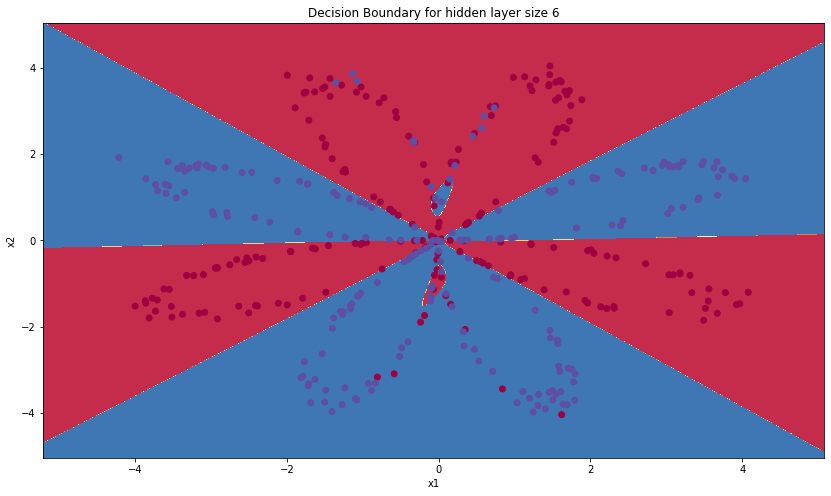

In [67]:
parameters = nn_model(X, Y, n_h = 6, num_iterations = 10000, print_cost=True)

# Отрисуем вывод нейросети на плоскости
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(6))

predictions = predict(parameters, X)
acc = 1 - (np.abs(Y-predictions).sum()/Y.size)
print(u'Качество модели (согласно метрике accuracy): %f ' %(acc))

Cost after iteration 0: 0.948592
Cost after iteration 1000: 0.219747
Cost after iteration 2000: 0.198865
Cost after iteration 3000: 0.189112
Cost after iteration 4000: 0.182971
Cost after iteration 5000: 0.178645
Cost after iteration 6000: 0.175455
Cost after iteration 7000: 0.173043
Cost after iteration 8000: 0.171219
Cost after iteration 9000: 0.170444
Качество модели (согласно метрике accuracy): 0.907500 


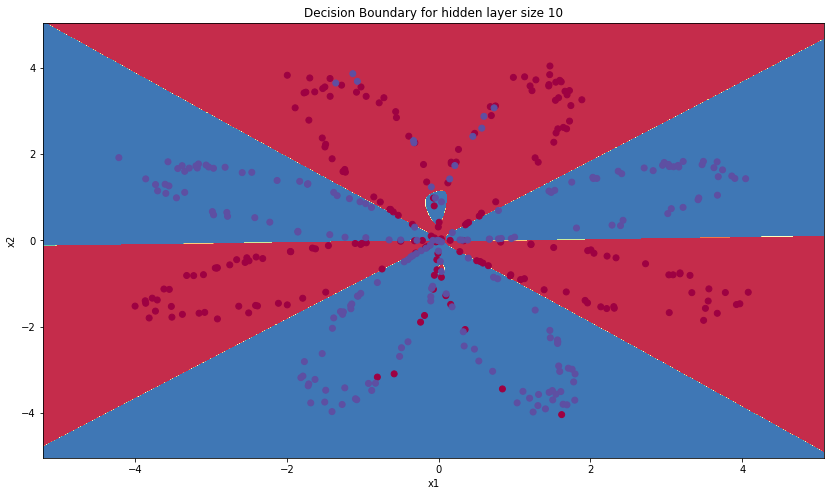

In [63]:
parameters = nn_model(X, Y, n_h = 10, num_iterations = 10000, print_cost=True)

# Отрисуем вывод нейросети на плоскости
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(10))

predictions = predict(parameters, X)
acc = 1 - (np.abs(Y-predictions).sum()/Y.size)
print(u'Качество модели (согласно метрике accuracy): %f ' %(acc))

Cost after iteration 0: 3.821810
Cost after iteration 1000: 0.243448
Cost after iteration 2000: 0.213188
Cost after iteration 3000: 0.202589
Cost after iteration 4000: 0.196905
Cost after iteration 5000: 0.191203
Cost after iteration 6000: 0.186092
Cost after iteration 7000: 0.180768
Cost after iteration 8000: 0.175864
Cost after iteration 9000: 0.172900
Качество модели (согласно метрике accuracy): 0.902500 


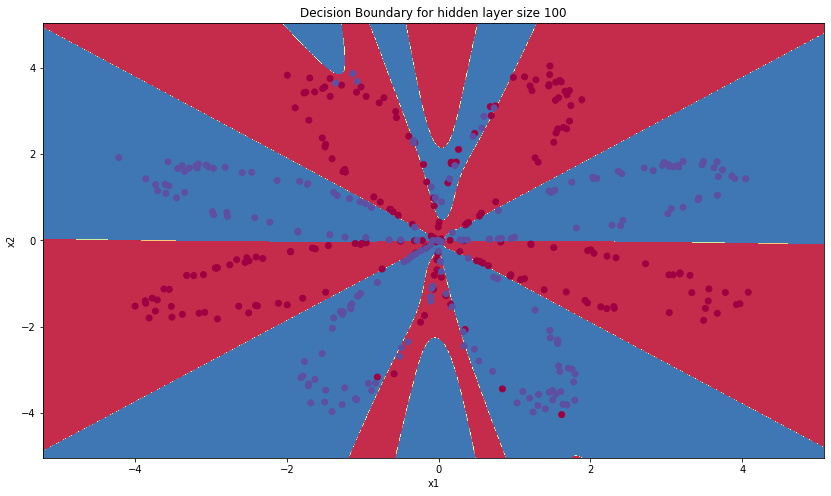

In [64]:
parameters = nn_model(X, Y, n_h = 100, num_iterations = 10000, print_cost=True)

# Отрисуем вывод нейросети на плоскости
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(100))

predictions = predict(parameters, X)
acc = 1 - (np.abs(Y-predictions).sum()/Y.size)
print(u'Качество модели (согласно метрике accuracy): %f ' %(acc))

После экспериментов с количеством нейронов в скрытом слое видно:

1.   Модели с количеством нейронов < 4 не способны восстановить исходную зависимость
2.    Модели с количеством нейронов 4 и 5 показывают лучшие результаты
3.     Модели с количеством нейронов > 5 склонны к переобучению

## Часть 3.  Немного о функциях активации и  градиентном спуске

Вспомним, что функция активации - это нелинейная функция одного переменного. Формально выбор этой функции ограничен только этим условием, но сложилось так, что используется обычно одна функция из следующего набора:

$$\tanh (x) = \frac{e^{2x} - 1}{e^{2x}+1} $$

$$ sigmoid (x) = \frac{e^x}{e^x+1} = \frac{1}{1+e^{-x}}$$

$$ ReLU (x) = \theta(x) \cdot x = \max(0,x)$$

$$ softplus (x) = \log(1+e^x)$$

и подобные им функции...

В 2010 году была опубликована статья [Deep Sparse Rectifier Neural Networks by Xavier Glorot et al.](https://drive.google.com/open?id=1hJE2vLvTF-A8Uq0GlQdZnGaTpHM_E9lh), в которой было показано, что использование функции ReLU ускоряет и улучшает процесс обучения глубоких нейросетей. Подробнее о причинах такого выбора мы поговорим позже, когда подробно будем разбирать проблемы оптимизации функции ошибки.

**Про шаг градиентного спуска (learning rate):**

мы использовали константный learning rate и в задаче логистической регрессии, и в данной задаче обучения нейросети. Такой подход часто приводит к плохим результатам, поэтому есть различные методики, в которых learning rate - это не константа, а какая-либо функция от номера итерации:

$$  \alpha = \alpha(n_{iter}).$$

<img src="https://drive.google.com/uc?export=view&id=1tk1bPg0x9niJGjm_Ov2Y4uJnne5qolTv" style="width:512px;height:512px;">

<img src="https://drive.google.com/uc?export=view&id=1ICmnBODWu8G7VgSelYuQw2KiyN2nB6pg" style="width:512px;height:512px;">


О непосредственном выборе функции мы также поговорим во время детального анализа проблем оптимизации, однако уже сейчас стоит помнить о такой проблеме.

### Часть 4. Метрики качества

В deep learning процесс и время обучения могут сильно зависеть от функции потерь, ведь именно эта функция оптимизируется на каждой итерации обучения (то есть происходит обновление параметров весов).

Однако часто функции потерь трудно интерпретировать, по их значениям сложно сделать вывод, насколько хорошо модель справляется со своей задачей. Поэтому появляется необходимость для оценивания качества модели по-другому. Для этого используются различные метрики. Они никак не влияют на процесс обучения, а просто подсчитываются для действующей модели и выводятся пользователю. Формально определять, что такое метрика, нет никакой необходимости, потому что мы в этой задаче рассмотрим типичные примеры функций, которые используются в большинчтве задач и на этом остановимся.

Определим сначала такое понятие как confusion matrix:

<img src="https://drive.google.com/uc?export=view&id=1FXEdlRMEaOhBsI30nroyYXlJtaIO4Co_" style="width:1064px;height:512px;">

Три самые главные метрики:
  
    -accuracy (доля правильных ответов): 
    
  $$accuracy = \frac{TP+TN}{TP+FP+TN+FN}  \tag{8.1}$$
  
    -precision (точность):
    
 $$ precision = \frac{TP}{TP+FP} \tag{8.2}$$
 
    -recall (полнота, охват):
    
$$ recall = \frac{TP}{TP+FN} \tag{8.3}$$

Полезно знать о еще одной метрике - $\textbf{F-score}$, которая является средним гармоническим от $\textit{precision}$ и $\textit{recall}$:

$$F_1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall} \tag{8.4}$$

Пока остановимся на этом. Далее вернёмся к разговору о метриках, когда будем обсуждать сверточные и рекуррентные нейросети.




In [ ]:
!nvidia-smi

Fri Mar  8 10:12:34 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    67W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
!ls

sample_data


In [ ]:
!cd sample_data